# Installing Packages

In [ ]:
!pip install -U torchtext==0.6.0

# Importing Required Libraries

In [2]:
import torch
from torchtext import data, datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, LabelField, BucketIterator

import random

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [4]:
SEED = 4444

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Generate NGRAMS for FastText

In [5]:
def generate_n_grams(x, n=2):
    n_grams = set(zip(*[x[i:] for i in range(n)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return list(set(x))

In [6]:
FIELD = Field(tokenize = 'spacy',tokenizer_language = 'en_core_web_sm', preprocessing = generate_n_grams)

LABEL = LabelField(dtype = torch.float)

# Splitting the data

In [7]:
train_data, test_data = datasets.IMDB.splits(FIELD, LABEL)

In [8]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [10]:
MAX_VOCAB_SIZE = 25000 # excluding <pad> and <unk> token

FIELD.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors="glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [11]:
print(f"Unique tokens in FIELD vocabulary: {len(FIELD.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in FIELD vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


# Model Definition

In [12]:
class FastText(nn.Module):
    def __init__(self, vocab_size, emb_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.fc = nn.Linear(emb_dim, output_dim)
        
    def forward(self, input):                                                   # [input] = [input_length, batch_size]
        embedded = self.embedding(input)                                        # [embedded] = [seq_len, batch_size, emb_dim]
        embedded = embedded.permute(1, 0, 2)                                    # [embedded] = [batch_size, seq_len, emb_dim]
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1))                 # [pooled] = [batch_size, 1, emb_dim] 
        pooled = pooled.squeeze(1)                                              # [pooled] = [batch size, embedding_dim]
        return self.fc(pooled)

In [13]:
def batch_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training and Evaluation Functions

In [14]:
def Train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        inp = batch.text
        label = batch.label    
        predictions = model(inp).squeeze(1)
        loss = criterion(predictions, label)
        acc = batch_accuracy(predictions, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [15]:
def Evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:  
            inp = batch.text
            label = batch.label     
            predictions = model(inp).squeeze(1)
            loss = criterion(predictions, label)
            acc = batch_accuracy(predictions, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Data Iterators, Hyperparameters and Model Initialization

In [16]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [17]:
VOCAB_SIZE = len(FIELD.vocab) # dimension of one-hot vector / vocabulary
EMB_DIM = 100 # dimension of word embeddings
OUTPUT_DIM = 1 # dimension of output layer

NUM_EPOCHS = 10
LR = 0.001

In [18]:
model = FastText(VOCAB_SIZE, EMB_DIM, OUTPUT_DIM, FIELD.vocab.stoi[FIELD.pad_token])

In [19]:
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


# Training

In [21]:
import time

def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
print(f"Learning Rate: {LR}")
train_losses = []
valid_losses = []
min_losses = [float('inf'), float('inf')]

start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    
    train_loss, train_acc = Train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_loss, valid_acc = Evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)

    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(model.state_dict(), 'FastText.pt')

    elapsed_time = Epoch_time(start_time, time.time())
    print(f"Time taken for epoch {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
    start_time = time.time()
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Training Accuracy: {train_acc*100:.2f} %| Validation Accuracy: {valid_acc*100:.2f} %")

print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001
Time taken for epoch 1: 0m 9s
Training Loss: 0.6900 | Validation Loss: 0.6643
Training Accuracy: 53.88 %| Validation Accuracy: 63.70 %
Time taken for epoch 2: 0m 8s
Training Loss: 0.6689 | Validation Loss: 0.5680
Training Accuracy: 70.73 %| Validation Accuracy: 75.88 %
Time taken for epoch 3: 0m 8s
Training Loss: 0.6161 | Validation Loss: 0.4792
Training Accuracy: 78.73 %| Validation Accuracy: 78.10 %
Time taken for epoch 4: 0m 8s
Training Loss: 0.5431 | Validation Loss: 0.3829
Training Accuracy: 83.51 %| Validation Accuracy: 83.00 %
Time taken for epoch 5: 0m 8s
Training Loss: 0.4712 | Validation Loss: 0.3528
Training Accuracy: 86.64 %| Validation Accuracy: 85.13 %
Time taken for epoch 6: 0m 8s
Training Loss: 0.4132 | Validation Loss: 0.3434
Training Accuracy: 88.35 %| Validation Accuracy: 86.67 %
Time taken for epoch 7: 0m 8s
Training Loss: 0.3627 | Validation Loss: 0.3479
Training Accuracy: 89.37 %| Validation Accuracy: 87.30 %
Time taken for epoch 8: 0m 8s
Trai

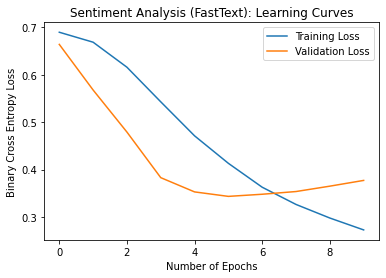

In [23]:
plt.title("Sentiment Analysis (FastText): Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()

# Testing

In [24]:
model.load_state_dict(torch.load('FastText.pt'))

test_loss, test_acc = Evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Loss: 0.3499
Test Accuracy: 86.28%


# Sampling

In [25]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, text):
    model.eval()
    tokenized = generate_n_grams([tok.text for tok in nlp.tokenizer(text)], n=2)
    indexed = [FIELD.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [26]:
predict_sentiment(model, "This film is not bad")

4.2760206042657956e-07

In [27]:
predict_sentiment(model, "This film is excellent")

1.0

In [28]:
predict_sentiment(model, "This film is bad")

2.538240104210665e-11